# **Ski Weather Conditions Final Code Report**

- Sarah Klute
- Shani Dor
- Ihunaya Eluwa
- Chiara Blake

## Pipeline:

In [1]:
# needed imports
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import MonthLocator
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_weather(latlon, s_date, e_date):
    ''' creates historical weather data for a given date and location
    
    args:
        latlon (tuple): tuple (lat, long)
        s_date (str): start date in format YYYY-MM-DD
        e_date (str): end date in format YYYY-MM-DD
    
    returns:
        weather_dict (json): return from API
    '''
    # separating tuple into lat and lon
    lat, lon = latlon
    
    # creating url to request - the timezone is set to always be Los Angeles
    url = f'https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={s_date}&end_date={e_date}&hourly=snow_depth&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,snowfall_sum,rain_sum,windspeed_10m_max&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch&timezone=America%2FLos_Angeles'
    url_text = requests.get(url).text
    
    # convert json to a nested dict
    weather_dict = json.loads(url_text)
    
    return weather_dict

In [3]:
def get_dates(start_year):
    ''' initialize a dictionary with the resort information for given year ski season
    
    args:
        start_year (str): the starting year for the season
    
    returns:
        resort_dict (dict): dictionary with the resorts and the specific dates to be analyzed 
    '''
    
    end_year = start_year + 1

    resort_dict = {
        'crystal mountain': {
            'latlon': (46.9282, -121.5045),
            'start_date': f'{start_year}-11-20',
            'end_date': f'{end_year}-04-01'
        },
        'jackson hole': {
            'latlon': (43.4799, -110.7624),
            'start_date': f'{start_year}-11-20',
            'end_date': f'{end_year}-04-01'
        },
        'vail': {
            'latlon': (39.6433, -106.3781),
            'start_date': f'{start_year}-11-20',
            'end_date': f'{end_year}-04-01'
        },
        'whistler': {
            'latlon': (50.1162, -122.9535),
            'start_date': f'{start_year}-11-20',
            'end_date': f'{end_year}-04-01'
        },
        'park city': {
            'latlon': (40.6461, -111.4980),
            'start_date': f'{start_year}-11-20',
            'end_date': f'{end_year}-04-01'
        },
    }
    return resort_dict

In [4]:
def hr_to_daily(hourly_data):
    ''' converts hourly data into daily data

    args:
        hourly_data (list): hourly data to be converted into daily

    returns:
        daily_list (list): list with the calculated daily data
    '''

    # initialize variables
    total = 0
    num = 24
    daily_list = []
    i = 0

    # loop through hourly data
    while i < len(hourly_data):
        # add to total
        total += hourly_data[i]

        # check if 24 hours have gone by
        if (i == num - 1):

            # add total to list
            daily_list.append(total)

            # reset for new day
            total = 0
            num += 24
        i+=1

    return daily_list

In [5]:
 
def season_stats(start_dates, leng):
    """ Store the data from the api of a given a season and resort into the dictionary which is then cast to a dataframe

    Args: 
        start_dates (list): list of dates
        leng (int): length of ski season 

    Returns:
        df_ski (dataframe): dataframe of each ski resort and weather data 

    """
    # create empty dict to store all data
    data_dict = {
        'resort': [], 'location': [], 'start_date': [], 'end_date': [], 'day_date': [], 
        'daily_max_temp': [], 'daily_min_temp': [], 
        'daily_mean_temp': [], 'daily_snowfall_sum': [],
        'daily_max_wind_speed': [], 'daily_rain_sum': [],
        'daily_snowdepth': [] 
    }


    # loop through each ski season 
    for yr in start_dates:

        # compiling dict per year
        resort_dict = get_dates(yr)
        for r in resort_dict:
            
            # get the latlang, start and end dates for each resort
            resort = resort_dict[r]
            weather = get_weather(resort['latlon'], resort['start_date'], resort['end_date'])
            
            # loop through for each day in season
            for i in range(leng):

                #get resort weather data for each resort over the given period
                data_dict['resort'].append(r)
                data_dict['location'].append(resort['latlon'])
                data_dict['start_date'].append(resort['start_date'])
                data_dict['end_date'].append(resort['end_date'])

                # data on a daily scale
                data_dict['day_date'].append(weather['daily']['time'][i])
                data_dict['daily_max_temp'].append(weather['daily']['temperature_2m_max'][i])
                data_dict['daily_min_temp'].append(weather['daily']['temperature_2m_min'][i])
                data_dict['daily_mean_temp'].append(weather['daily']['temperature_2m_mean'][i])
                data_dict['daily_snowfall_sum'].append(weather['daily']['snowfall_sum'][i])
                data_dict['daily_max_wind_speed'].append(weather['daily']['windspeed_10m_max'][i])
                data_dict['daily_rain_sum'].append(weather['daily']['rain_sum'][i])
                data_dict['daily_snowdepth'].append(hr_to_daily(weather['hourly']['snow_depth'])[i]/24)
    
    df_ski = pd.DataFrame(data_dict)
    return df_ski

# setting up dates for dataframe
start_dates = [2018,2019,2020,2021]

# set length equal to number of datapoints (days in 1 season)
leng = 133

df_ski = season_stats(start_dates, leng)
df_ski.head()

resort              location  start_date    end_date    day_date  \
0  crystal mountain  (46.9282, -121.5045)  2018-11-20  2019-04-01  2018-11-20   
1  crystal mountain  (46.9282, -121.5045)  2018-11-20  2019-04-01  2018-11-21   
2  crystal mountain  (46.9282, -121.5045)  2018-11-20  2019-04-01  2018-11-22   
3  crystal mountain  (46.9282, -121.5045)  2018-11-20  2019-04-01  2018-11-23   
4  crystal mountain  (46.9282, -121.5045)  2018-11-20  2019-04-01  2018-11-24   

   daily_max_temp  daily_min_temp  daily_mean_temp  daily_snowfall_sum  \
0            38.7            25.0             32.2               0.000   
1            34.2            27.0             30.2               2.591   
2            26.5            20.9             24.3               5.622   
3            22.8            18.0             20.2               6.587   
4            25.5             8.7             17.9               0.000   

   daily_max_wind_speed  daily_rain_sum  daily_snowdepth  
0                   6.0           0.000         0.066000  
1                   9.6           0.000         0.079500  
2                  11.6           0.004         0.255750  
3                   6.7           0.000         0.641083  
4                   7.2           0.000         0.799375

In [6]:
# create new empty dataframe for scaling
scaled_df = pd.DataFrame()

cols = ['daily_max_temp', 'daily_min_temp', 'daily_mean_temp',
       'daily_snowfall_sum', 'daily_max_wind_speed', 'daily_rain_sum',
       'daily_snowdepth']

# scaling the data 
for feat in cols:
    scaled_df[f'{feat}_scaled'] = df_ski[feat] / df_ski[feat].std()

scaled_df = scaled_df.round(2) 
scaled_df.head()

daily_max_temp_scaled  daily_min_temp_scaled  daily_mean_temp_scaled  \
0                   4.44                   2.52                    3.87   
1                   3.92                   2.73                    3.63   
2                   3.04                   2.11                    2.92   
3                   2.61                   1.82                    2.43   
4                   2.92                   0.88                    2.15   

   daily_snowfall_sum_scaled  daily_max_wind_speed_scaled  \
0                       0.00                         2.49   
1                       0.97                         3.98   
2                       2.10                         4.81   
3                       2.46                         2.78   
4                       0.00                         2.99   

   daily_rain_sum_scaled  daily_snowdepth_scaled  
0                   0.00                    0.02  
1                   0.00                    0.02  
2                   0.05                    0.08  
3                   0.00                    0.20  
4                   0.00                    0.25

## Visualizations:

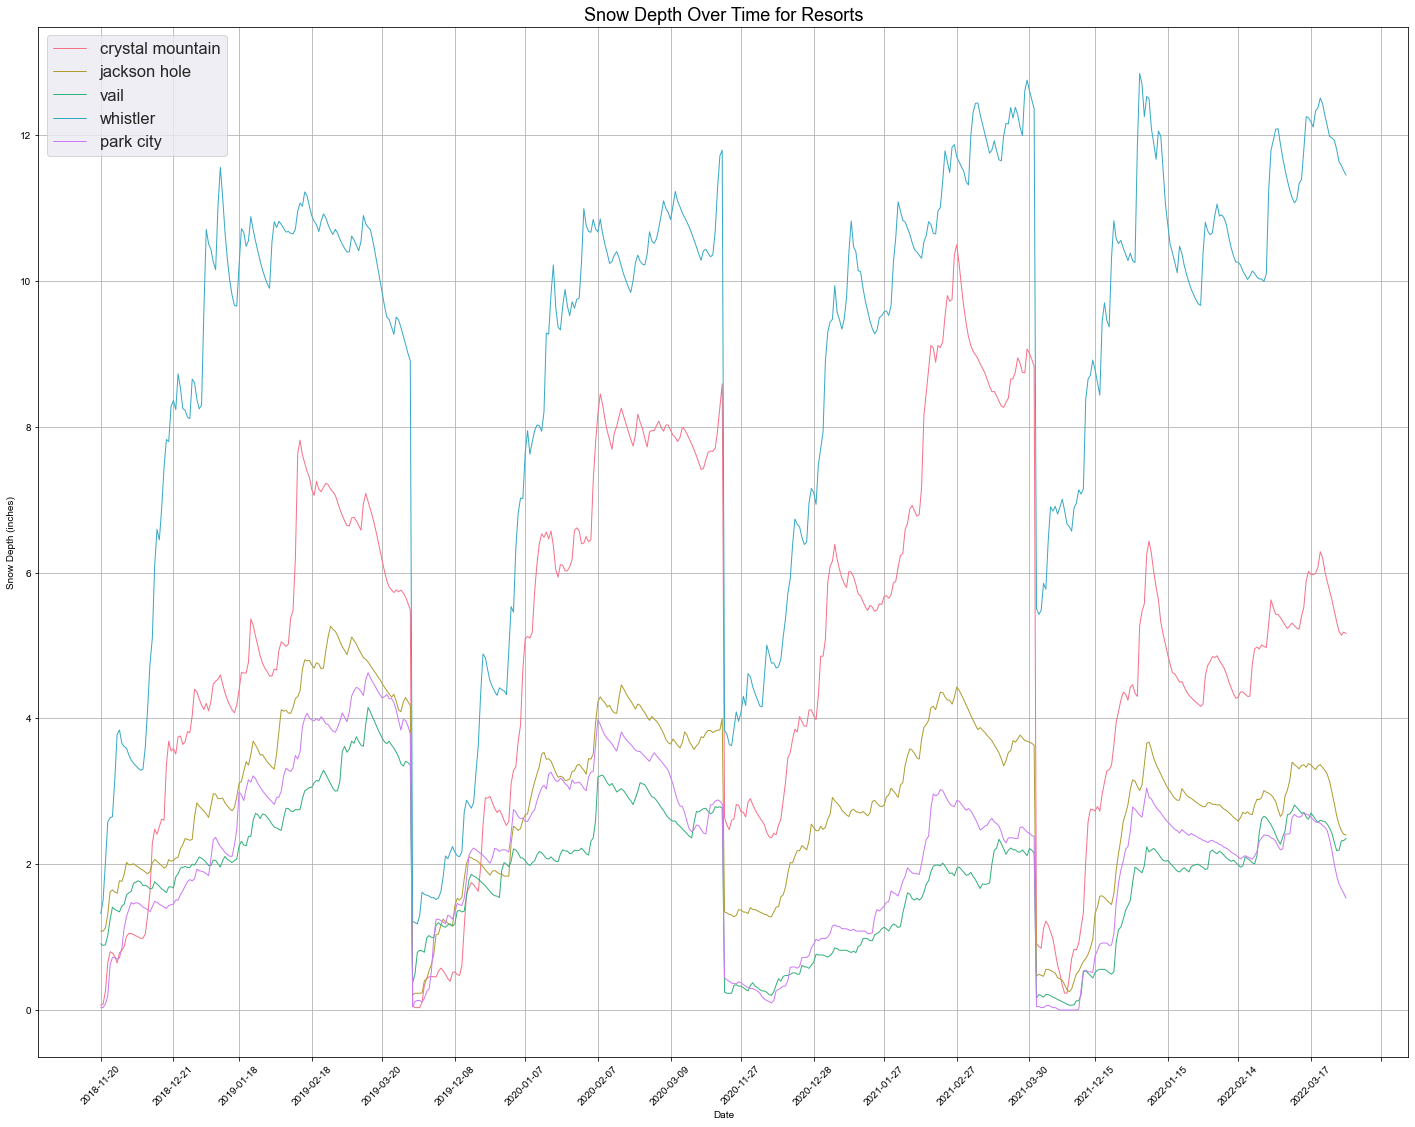

In [7]:
## visualization one: how snowdepth has changed over time for resorts
fig, ax = plt.subplots(figsize=(20, 16))
sns.set(font_scale=1.5)

# palette for different resorts
palette = sns.color_palette("husl", len(df_ski['resort'].unique()))

for i, resort in enumerate(df_ski['resort'].unique()):
    resort_data = df_ski[df_ski['resort'] == resort]
    sns.lineplot(
        data=resort_data,
        x="day_date", y="daily_snowdepth",
        estimator=None, lw=1,
        color=palette[i],  
        label=resort, 
    )

plt.xlabel('Date')
plt.ylabel('Snow Depth (inches)')
plt.title('Snow Depth Over Time for Resorts')
plt.grid(True)  
plt.xticks(rotation=45) 

# cleaning axis 
ax.xaxis.set_major_locator(MonthLocator())
plt.legend(loc='upper left') 
plt.tight_layout()  
plt.show()

### Analysis
This graph compares the daily snow depths at each of the 5 resorts. It gives insights into which resorts consistently have a greater snow depth revealing Whistler and Crystal mountains superiority comparatively. Additionally, over the 4-year period, the graph shows which resorts have experienced significantly decreasing snow depths from years previously. Crystal in 2022, compared to the previous season, as seen diminishing levels. Finally, we can also see the when snow depth levels peaked for each resort each ski season. In 2022, all resorts, but specifically Whistler, saw snow depth levels peaking much earlier in the season (between December and January) compared to years previously where peaks occurred later into the season. 

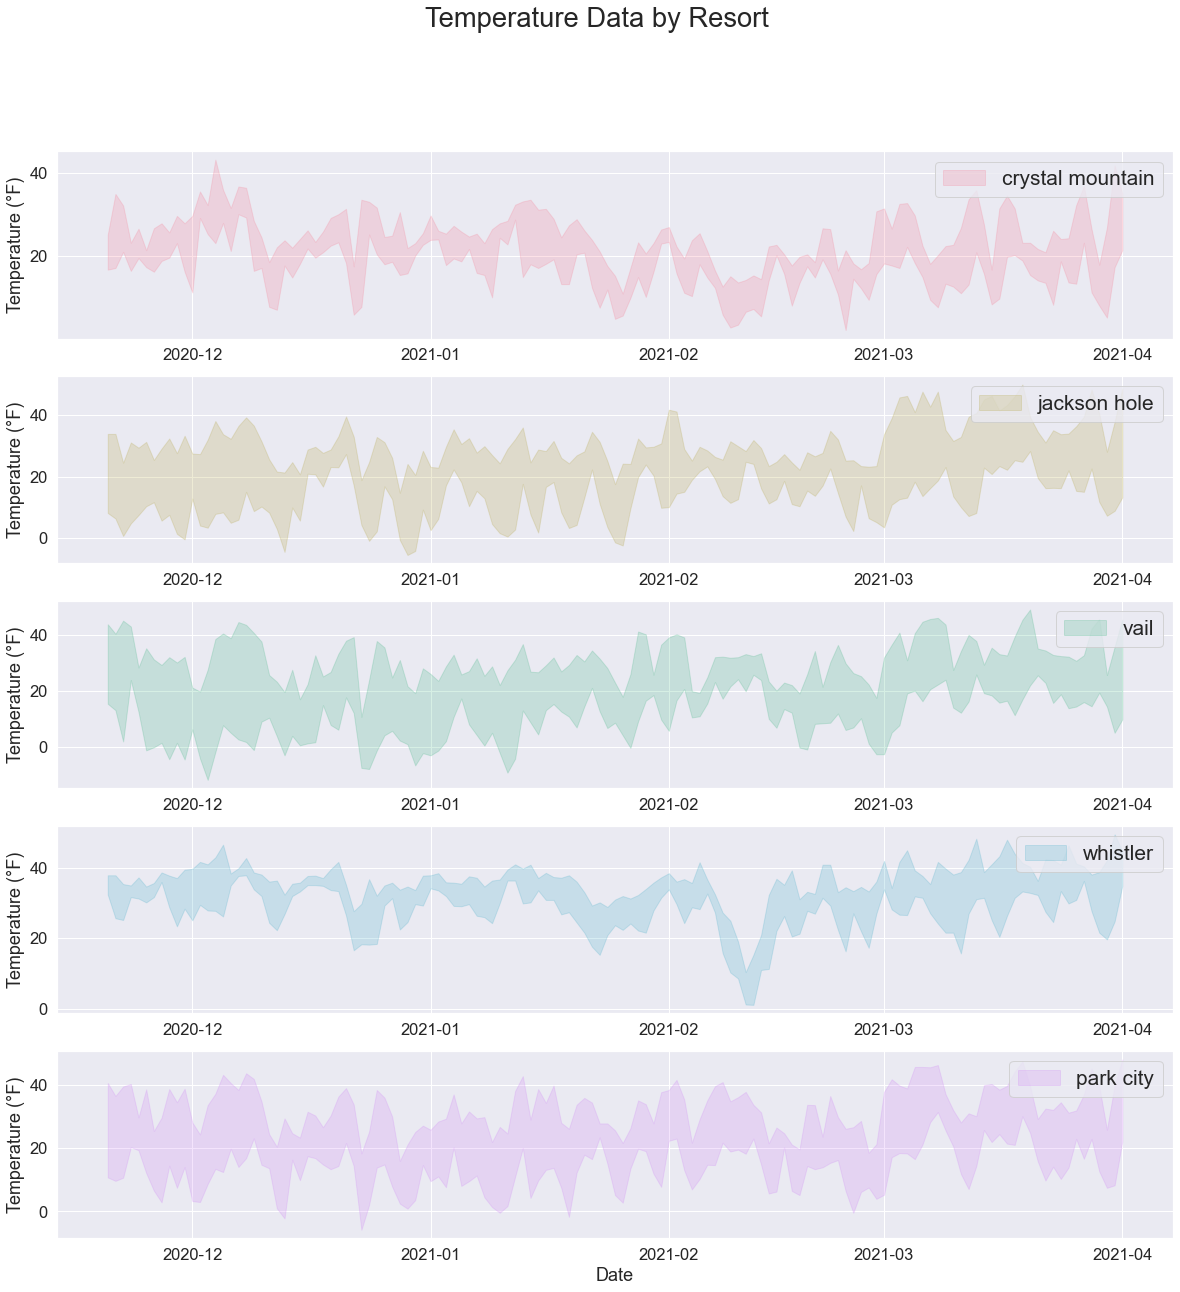

In [8]:
# visualization two: daily temp over a ski season

# Get data from November to April
start_date = '2020-11-01'
end_date = '2021-04-01'

# Convert the strings to datetime objects
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# change dates to datetime obj
df_ski_datetime = df_ski
df_ski_datetime['day_date'] = pd.to_datetime(df_ski_datetime['day_date'])

# get a filtered data frame of the 2020 to 2021 ski season
date_range_bool = (df_ski_datetime['day_date'] >= start_date) & (df_ski_datetime['day_date'] <= end_date)
df_ski_filtered = df_ski_datetime[date_range_bool]

# list of unique resorts
unique_resorts = df_ski_filtered['resort'].unique()

# palette for different resorts
palette = sns.color_palette("husl", len(df_ski['resort'].unique()))

fig, axes = plt.subplots(len(unique_resorts), 1, figsize=(20,4*len(unique_resorts)))
sns.set(font_scale=1.9)


# itterate through the data frame by resort
for i, resort in enumerate(unique_resorts):
    resort_data = df_ski_filtered[df_ski_filtered['resort'] == resort]
    
    # make a fill between plot potentialy of data for each mountain ^ have to stop the boolean indexing at the top
    ax = axes[i] 
    ax.fill_between(x = resort_data['day_date'], 
                    y1 = resort_data['daily_min_temp'],
                    y2 = resort_data['daily_max_temp'],
                    alpha = 0.2,
                    label = resort,
                    color = palette[i])
    
    # Display months
    ax.xaxis.set_major_locator(MonthLocator())

    # Add labels, legend, and show the plot
    ax.set_ylabel('Temperature (°F)')
    ax.legend()
    ax.grid(True)

plt.xlabel('Date')
plt.tight_layout
plt.suptitle('Temperature Data by Resort')
plt.show()

### Analysis
This graph shows the daily temperature data by resort of the 2020-2021 ski season. Daily minimum and maximum temperatures are helpful in determining if it is a good day for skiing. Temperature affects snowpack and the feeling of the snow (icy/powdery). If daily temperatures are typically optimal during a month (or any time period) we can use that to predict a month with ideal skiing conditions. For example Park City sees temperatures with a low below 20 during the month of February and a high above 20 during the month of March, if this trend is observed over multiple years we can deduce that February is a better month for skiing than March because the temperatures are lower.

In [9]:
# visualize snow depth and temperature
px.scatter(data_frame = df_ski, x='daily_mean_temp', y='daily_snowdepth', 
           color='resort',title = "Snow Depth vs Average Temp")

### Analysis
This graph illustrates that Whistler tends to have the highest snow depth in general. The data seems to be stratified and ordered in relationship to the amount of snow depth at various temperates. Whistler appears to consistently have the most depth followed by Crystal Mountain, with the rest being about the same (Jackson Hole, Vail, and Park City). This can provide us insight in regards to how we recommend the optimal ski resort for the conclusion of the project. The graph shows that as the daily temperature increases, there is no specific movement as it relates to daily snow depth. Thus, although this graph doesn't exactly illustrate a relationship between daily temperatures and daily snow depth, it is helpful for us to see the differences between resorts.

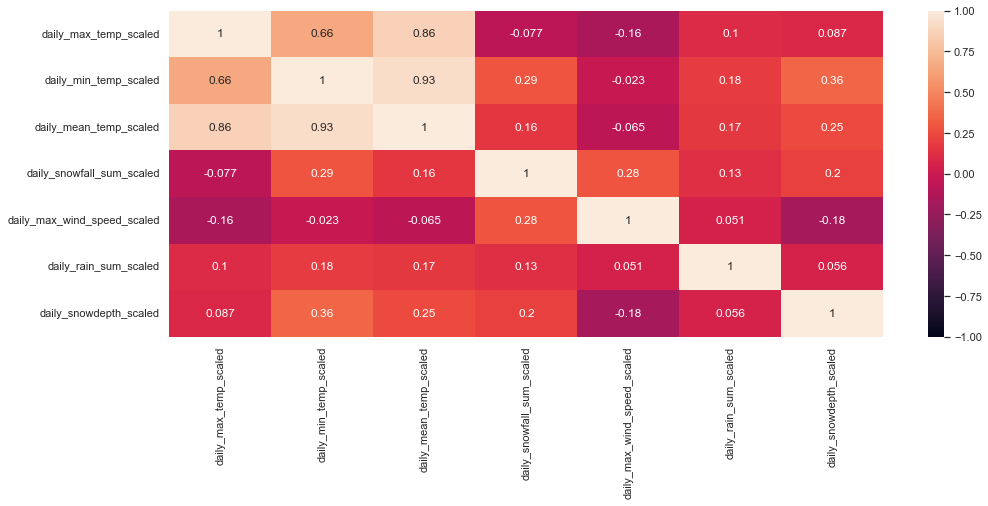

In [10]:
# increase the size of the heatmap
plt.figure(figsize=(16, 6))
sns.set(font_scale=1)

# heatmap of correlation values
sns.heatmap(scaled_df.corr(),vmin = -1, vmax =1, annot=True);

### Analysis
The correlation matrix gives us an initial sense as to which features might have a relationship. At first glance, the minimum and average temp have a strong positive correlation, which is logical as they are somewhat dependent features because the mean temp uses the minimum temp in its calculation. Another positive correlation is seen between the minimum temp and the snow depth. While the correlation is not strong, 0.39 indicates there might be a slight relationship there worth exploring. 

## Method

In [11]:
scaled_df.columns

Index(['daily_max_temp_scaled', 'daily_min_temp_scaled',
       'daily_mean_temp_scaled', 'daily_snowfall_sum_scaled',
       'daily_max_wind_speed_scaled', 'daily_rain_sum_scaled',
       'daily_snowdepth_scaled'],
      dtype='object')

In [12]:
x_feat_list = ['daily_max_temp_scaled', 'daily_min_temp_scaled', 'daily_mean_temp_scaled', 'daily_snowfall_sum_scaled', 'daily_max_wind_speed_scaled', 'daily_rain_sum_scaled']
y_feat = 'daily_snowdepth_scaled'

In [13]:
# performing random forest regression
n_splits = 10

# extract features
x = scaled_df.loc[:, x_feat_list].values
y_true = scaled_df.loc[:, y_feat].values

# initiate random forest
rf_reg = RandomForestRegressor()

# cross validate loop
y_pred = copy(y_true)
kfold = KFold(n_splits=n_splits, shuffle=True)
for train_idx, test_idx in kfold.split(x, y_true):
    # extract x, y feat for cross validation loop
    x_train = x[train_idx, :]
    x_test = x[test_idx, :]
    y_train = y_true[train_idx]
    
    # fit model from training data, predict on test data
    rf_reg.fit(x_train, y_train)
    y_pred[test_idx] = rf_reg.predict(x_test)

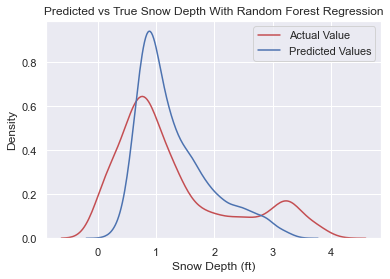

In [14]:
warnings.filterwarnings('ignore')

# visualize actual versus predicted values using random forest regression on full dataset 
ax1 = sns.distplot(y_true, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)
plt.legend()
plt.xlabel('Snow Depth (ft)') 
plt.title('Predicted vs True Snow Depth With Random Forest Regression');

In [15]:
# finding the feature importances 
sns.set(font_scale=1.2)

def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ Plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(% increase in R^2 due to each feature)')

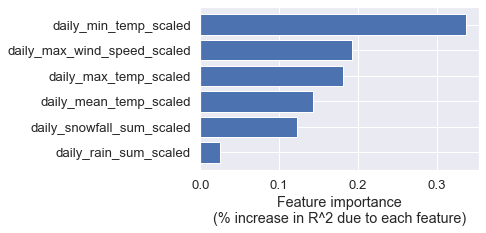

In [16]:
# extract features
x = scaled_df.loc[:, x_feat_list].values
y = scaled_df.loc[:, y_feat].values

# initialize and fit regressor (on whole dataset)
rf_reg = RandomForestRegressor()
rf_reg.fit(x, y)

# plot feature importance
plot_feat_import(feat_list=x_feat_list, feat_import=rf_reg.feature_importances_)

In [17]:
#create dictionary with features and their importances
ft_import = {x_feat_list[i]: rf_reg.feature_importances_[i] for i in range(len(x_feat_list))}

#dict with features above 0.10 reduction of MSE, initializing threshold
most_impt = {key:val for (key,val) in ft_import.items() if val >= 0.1} 

#sum those features
sum_feats = sum(most_impt.values())

impt_x_feat_list = list(most_impt.keys())
print(impt_x_feat_list)
print('sum: ', sum_feats)

['daily_max_temp_scaled', 'daily_min_temp_scaled', 'daily_mean_temp_scaled', 'daily_snowfall_sum_scaled', 'daily_max_wind_speed_scaled']
sum:  0.9756357938704813


From the feature importance graph, it is evident that certain features are more impactful than others. The daily max temp, daily min temp, daily mean temp, daily snowfall sum, and daily max wind speed account for about 97.6% of the variability in snow depth. Thus, we will use these features in our multiple regression model to minimize some complexity.

In [18]:
# looking at important features
for feat in impt_x_feat_list:
    print(feat)

daily_max_temp_scaled
daily_min_temp_scaled
daily_mean_temp_scaled
daily_snowfall_sum_scaled
daily_max_wind_speed_scaled


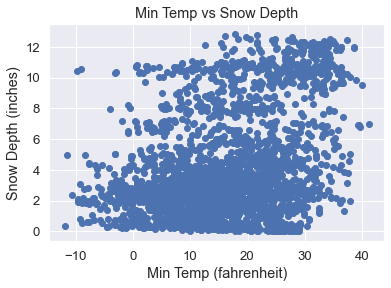

In [19]:
#plotting min temp vs snow depth
plt.scatter(df_ski.daily_min_temp, df_ski.daily_snowdepth)
plt.title('Min Temp vs Snow Depth')
plt.xlabel('Min Temp (fahrenheit)')
plt.ylabel('Snow Depth (inches)');

Since we found that minimum temperature is most important in increasing r2, this plot helps to visualize what the data looks like. The plot of min temp by snow depth doesn't look linear or polynomial at first glance. This is an initial observation that is helpful to note before testing both models.

## Multiple Regression Model

In [20]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_true - y_pred) ** 2)

In [21]:
# create X array with all features
all_mult_X = np.array(scaled_df.iloc[:,:-1])

In [22]:
# get the outcome vector
mult_y = np.array(scaled_df.loc[:,'daily_snowdepth_scaled'])

# single-fold cross validation with each model
crossval = train_test_split(all_mult_X, mult_y, test_size=0.3)

Xtrain, Xtest, ytrain, ytest = crossval

# set up model using scikit-learn
train_model = LinearRegression()

# fit the model
train_model.fit(Xtrain, ytrain)

# get the predictions for the test set
test_pred = train_model.predict(Xtest)

# calculate mse and r2
mse = get_mse(ytest, test_pred)
r2 = r2_score(ytest, test_pred)

#print the r2 and mse with all features
print('MSE: ',mse, 'r2: ', r2)

MSE:  0.7731188249177409 r2:  0.19288406132969105


In [23]:
# empty predictor array
mult_X = []

# loop through scaled data frame
for col, row in scaled_df.iteritems():
    #if feature is important, add value to X array
    if col in impt_x_feat_list:
        mult_X.append(scaled_df[col])
        
# transpose X array so each column is a different feature
mult_X = np.array(mult_X).T

In [24]:
# single-fold cross validation with each model
crossval = train_test_split(mult_X, mult_y, test_size=0.3)

Xtrain, Xtest, ytrain, ytest = crossval

# set up model using scikit-learn
train_model = LinearRegression()

# fit the model
train_model.fit(Xtrain, ytrain)

# get the predictions for the test set
test_pred = train_model.predict(Xtest)

# calculate mse and r2
mse = get_mse(ytest, test_pred)
r2 = r2_score(ytest, test_pred)

#print mse and r2 with only important features
print('MSE: ',mse, 'r2: ', r2)

MSE:  0.8085022889690119 r2:  0.23722932170240363


In comparing the two multiple regression models, we can see that the r2 increased slightly with the model using only important features.

## Polynomial Regression Model

In [25]:
# polynomial feature
X_mintemp = np.array(df_ski['daily_min_temp']).reshape(-1,1)

# get the poly outcome vector
poly_y = np.array(df_ski.loc[:,'daily_snowdepth'])

### Testing polynomial regression degrees

In [26]:
def cross_val_r2(x, y, degree, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)

    args:
        x (array): array of features
        y (array): array of outcome feature
        degree (int): number of degrees for polynomial
        n_splits (int): number of splits for cross fold validation

    returns:
        r2 (float): the calculated r2 percentage 
    
    """
    # project x to polynomial
    poly_project = PolynomialFeatures(degree=degree)
    X_poly = poly_project.fit_transform(x)
        
    # initialize empty y predictions
    y_pred = np.empty_like(y)

    # this implements k-fold cross validation based on the number of splits in the data
    kfold = KFold(n_splits=n_splits)
    
    #split data into the chunks. For each chunk, do linear regression
    for train_idx, test_idx in kfold.split(X_poly, y):
        # split data
        X_poly_test = X_poly[test_idx, :]
        X_poly_train = X_poly[train_idx, :]
        y_train = y[train_idx]
        
        # fit
        b_train = np.matmul(np.linalg.inv(np.matmul(X_poly_train.T, X_poly_train)), np.matmul(X_poly_train.T, y_train))
        
        # predict
        y_pred[test_idx] = np.matmul(X_poly_test, b_train)
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

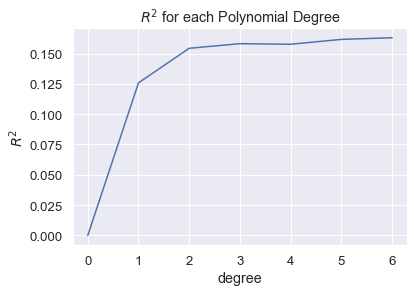

<Figure size 432x288 with 0 Axes>

In [27]:
X_poly_min = np.array([[1] * len(poly_y),
               df_ski.daily_min_temp]).T

# plotting the r2 for each degree polynomial
r2_per_degree = list()
for degree in range(7):
    r2 = cross_val_r2(X_poly_min[:,1].reshape(-1,1), poly_y, degree, n_splits=len(y))
    r2_per_degree.append(r2)
    
r2_per_degree = np.maximum(np.array(r2_per_degree), 0)

plt.plot(r2_per_degree)
plt.xlabel('degree')
plt.ylabel(f'$R^2$')
plt.title(f'$R^2$ for each Polynomial Degree')
plt.figure();

Looking at the r2 for different degree polynomials, although there is an initial elbow at degree 1, we will be testing degree 2 because it has a significantly higher r2 and while also being a simple model. 

In [28]:
# creating polynomial array
degree = 2
poly_feat = PolynomialFeatures(degree = degree)
X_poly = poly_feat.fit_transform(X_mintemp)

# removing the bias col
X_poly = np.delete(X_poly, 0 , 1)

# Single-fold cross validation
crossval = train_test_split(X_poly, poly_y, test_size=0.3)

Xtrain, Xtest, ytrain, ytest = crossval

#set up model using scikit-learn
train_model = LinearRegression()

#fit the model
train_model.fit(Xtrain, ytrain)

#get the predictions for the test set
test_pred = train_model.predict(Xtest)

#calculate mse and r2
mse = get_mse(ytest, test_pred)
r2 = r2_score(ytest, test_pred)

print('MSE: ',mse, 'r2: ', r2)

MSE:  9.196822631171141 r2:  0.14376118278689132


In initial comparison, the cross validated r2 for the multiple regression model is higher than the r2 for the polynomial model.

## Results

### Multiple Regression Model on Full Dataset

In [29]:
# get the outcome vector
y = np.array(scaled_df.loc[:,'daily_snowdepth_scaled'])

# set up model using scikit-learn
full_model = LinearRegression()

# fit the model to full dataset
full_model.fit(mult_X, y)

# get the predictions for the  dataset
full_pred = full_model.predict(mult_X)

# calculate mse and r2
mse = get_mse(y, full_pred)
r2 = r2_score(y, full_pred)

# calculate residuals
residuals = y - full_pred

print('MSE: ',mse, 'r2: ', r2)

MSE:  0.7779313144780146 r2:  0.22177272038395224


In [30]:
print('Intercept: ', full_model.intercept_, 'Slopes: ', full_model.coef_)

Intercept:  2.1139659351771343 Slopes:  [-0.07085666  0.77158019 -0.43588793  0.10534896 -0.22962698]


### Multiple Regression Model
$\hat{y} = 2.11 - 0.07x_1 + 0.77x_2 - 0.44x_3 + 0.11x_4 - 0.23x_5$


where
- $y$: `snow depth`
- $x_1$: `daily max temp scaled`, maximum temperature of that day
- $x_2$: `daily min temp scaled`, minimum temperature of that day
- $x_3$: `daily mean temp scaled`, mean temperature of that day
- $x_4$: `daily snowfall sum scaled`, total snowfall of that day
- $x_5$: `daily max wind speed scaled`, maximum wind speed of that day


## Assumptions

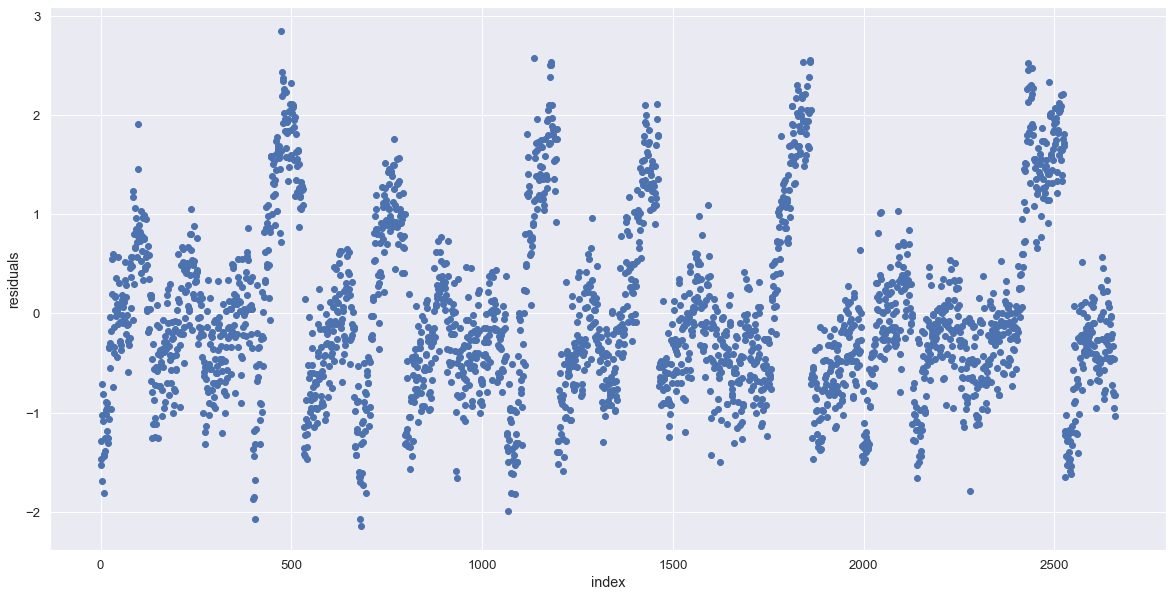

In [31]:
# plot of the index vs. the residuals
plt.scatter(x = range(len(y)), y = residuals)
plt.xlabel('index')
plt.ylabel('residuals')
plt.gcf().set_size_inches(20, 10);

The independence plot displays a pattern shown amongst the residuals from our model. Our data set is representative of four snow seasons from 2018, 2019, 2020, and 2021. This explains the four groups within the graph that look really similar to each other. Within each year section there are grouped clusters that are representative of each resort. This condition is not met.

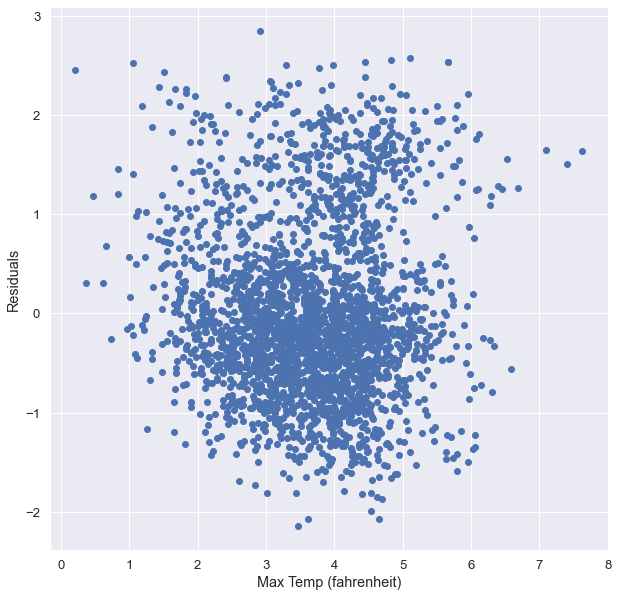

In [32]:
# plot of daily max temp scaled vs. the residuals
plt.scatter(x = scaled_df.daily_max_temp_scaled, y = residuals)
plt.xlabel("Max Temp (fahrenheit)")
plt.ylabel("Residuals")
plt.gcf().set_size_inches(10, 10);

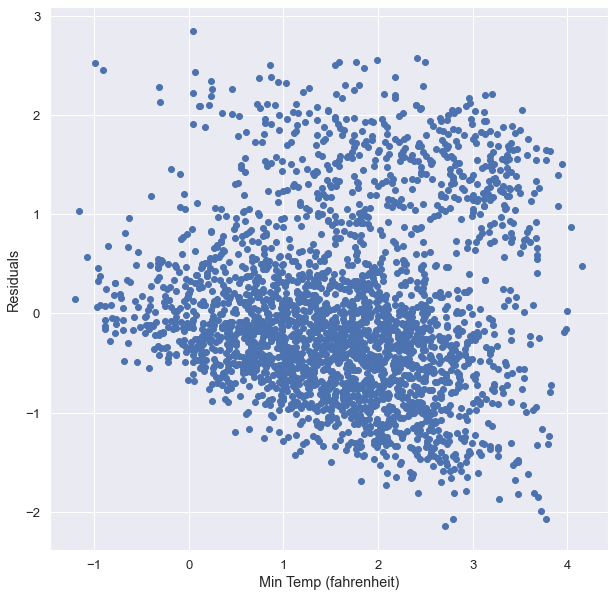

In [33]:
# plot of daily min temp scalled vs. the residuals
plt.scatter(x = scaled_df.daily_min_temp_scaled, y = residuals)
plt.xlabel("Min Temp (fahrenheit)")
plt.ylabel("Residuals")
plt.gcf().set_size_inches(10, 10);

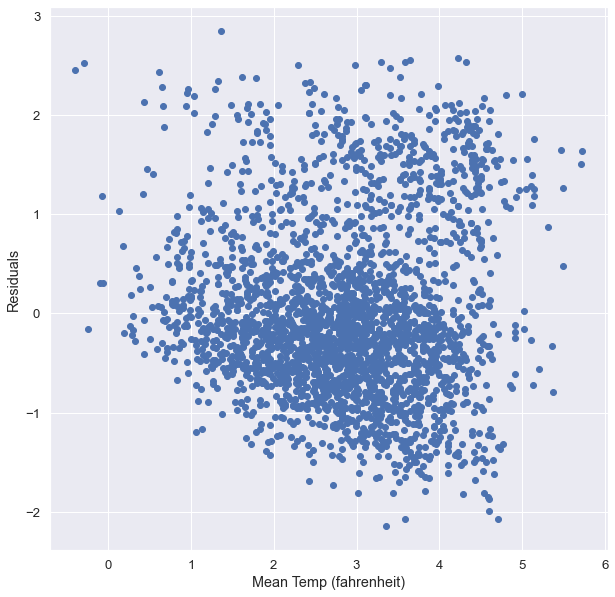

In [34]:
# plot of daily mean temp scaled vs. the residuals
plt.scatter(x = scaled_df.daily_mean_temp_scaled, y = residuals)
plt.xlabel("Mean Temp (fahrenheit)")
plt.ylabel("Residuals")
plt.gcf().set_size_inches(10, 10);

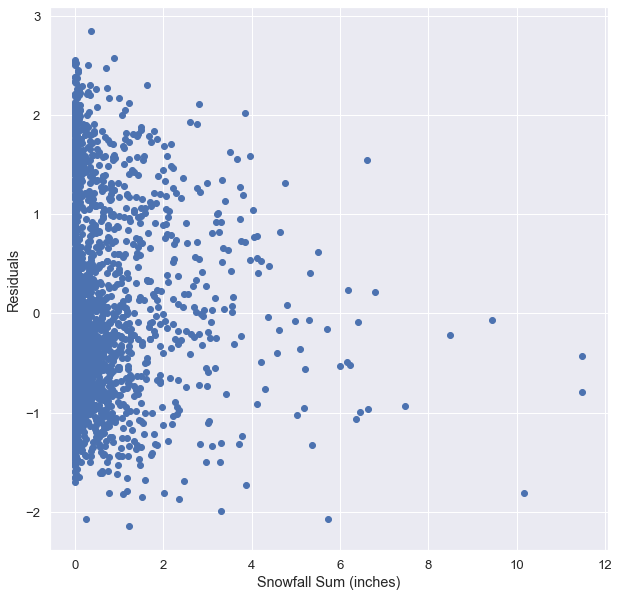

In [35]:
# plot of snowfall sum scaled vs. the residuals
plt.scatter(x = scaled_df.daily_snowfall_sum_scaled, y = residuals)
plt.xlabel("Snowfall Sum (inches)")
plt.ylabel("Residuals")
plt.gcf().set_size_inches(10, 10);

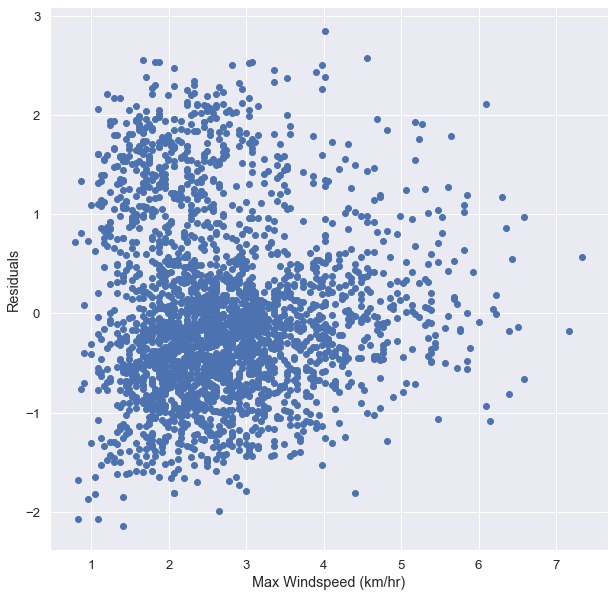

In [36]:
# plot of daily max wind speed scaled vs. the residuals
plt.scatter(x = scaled_df.daily_max_wind_speed_scaled, y = residuals)
plt.xlabel("Max Windspeed (km/hr)")
plt.ylabel("Residuals")
plt.gcf().set_size_inches(10, 10);

Max temp is the singular feature that appears to have constant variability across various temperatures.  The remaining four features all have some aspect of funneling for various values of the respective x feature as shown in the visuals below. This condition is also not met.

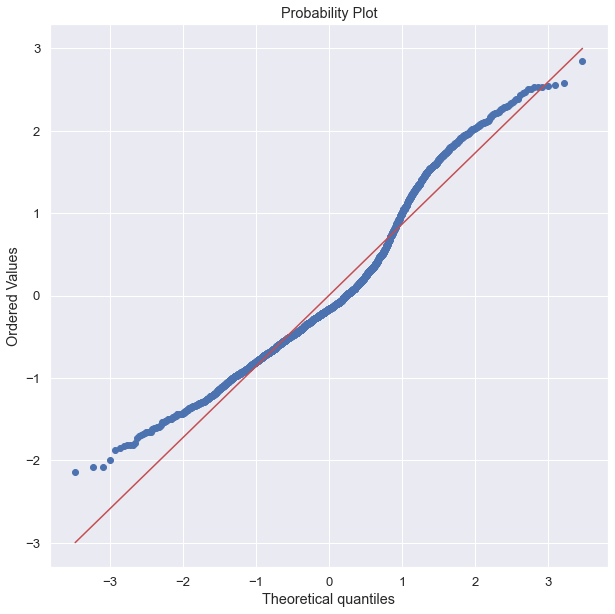

In [37]:
# normal probability quantile-quantile plot of the residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.gcf().set_size_inches(10, 10)
plt.show()

In checking the assumption of normality, we found that a lot of the errors do not lay close to the 45 degree line. The residuals appear to consistently deviate from the line. From this, we can conclude that this assumption is not met. Since neither of the three assumptions we met, we can conclude that our Multiple Linear Regression model was not the best decision for predicting our target variable.

### Visualizing the model

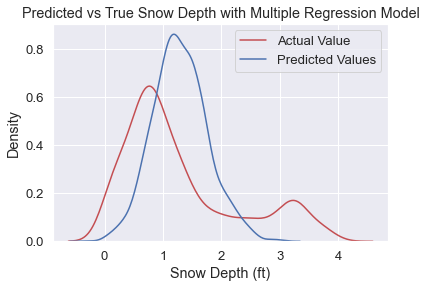

In [38]:
#visualize actual versus predicted values using random forest regression on full dataset 
ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(full_pred, hist=False, color="b", label="Predicted Values" , ax=ax1)
plt.legend()
plt.xlabel('Snow Depth (ft)') 
plt.title('Predicted vs True Snow Depth with Multiple Regression Model');

Our model is very inconsistent in predicting snow depth based on this visual. It goes from under-predicting to over predicting, back to under predicting.